In [1]:
#hide
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

# Convolutional Neural Networks

Here, we will begin by digging into what convolutions are and building a CNN from scratch. We will then study a range of techniques to improve training stability and learn all the tweaks the library usually applies for us to get great results.

## The Magic of Convolutions

One of the most powerful tools that machine learning practitioners have at their disposal is *feature engineering*. 

>A *feature* is a transformation of the data which is designed to make it easier to model. 

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that. On the other hand, the number 3 is characterized by a diagonal edge in one direction at the top left and bottom right of the digit, the opposite diagonal at the bottom left and top right, horizontal edges at the middle, top, and bottom, and so forth. 

So what if we could extract information about where the edges occur in each image, and then use that information as our features, instead of raw pixels?

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use something called a **convolution**. A convolution requires nothing more than multiplication and addition.

A convolution applies a **kernel** across an image. A kernel is usually a little matrix, such as the 3×3 matrix in the top right of the figure.

<img src="images/Lesson_06_conv_basic.png" caption="Applying a kernel to one location" alt="Applying a kernel to one location" width="700">

The 7×7 grid to the left is the *image* we're going to apply the kernel to. The convolution operation multiplies each element of the kernel by each element of a 3×3 block of the image. The results of these multiplications are then added together. 

Let's do this with code. First, we create a little 3×3 matrix like so:

In [2]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

Let's take an image:

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

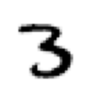

In [5]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

Now we're going to take the top 3×3-pixel square of our image, and multiply each of those values by each item in our kernel. Then we'll add them up, like so:

In [6]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [7]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

Not very interesting so far—all the pixels in the top-left corner are white. But let's pick a couple of more interesting spots:

In [8]:
#hide_output
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


There's a top edge at cell 5,8. Let's repeat our calculation there:

In [9]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

There's a right edge at cell 8,18. What does that give us?:

In [10]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

As you can see, this little calculation is returning a high number where the 3×3-pixel square represents a top edge (i.e., where there are low values at the top of the square, and high values immediately underneath). That's because the `-1` values in our kernel have little impact in that case, but the `1` values have a lot.

Let's look a tiny bit at the math. The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$. If we are in a part of the image where $a1$, $a2$, and $a3$ add up to the same as $a7$, $a8$, and $a9$, then the terms will cancel each other out and we will get 0. However, if $a7$ is greater than $a1$, $a8$ is greater than $a2$, and $a9$ is greater than $a3$, we will get a bigger number as a result. So this filter detects horizontal edges—more precisely, edges where we go from bright parts of the image at the top to darker parts at the bottom.

Changing our filter to have the row of `1`s at the top and the `-1`s at the bottom would detect horizontal edges that go from dark to light. Putting the `1`s and `-1`s in columns versus rows would give us filters that detect vertical edges. Each set of weights will produce a different kind of outcome.

Let's create a function to do this for one location, and check it matches our result from before:

In [11]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [12]:
apply_kernel(5,7,top_edge)

tensor(762.)

But note that we can't apply it to the corner (e.g., location 0,0), since there isn't a complete 3×3 square there.

### Mapping a Convolution Kernel

We can map `apply_kernel()` across the coordinate grid. That is, we'll be taking our 3×3 kernel, and applying it to each 3×3 section of our image. 

<img src="images/Lesson_06_nopadconv.svg" id="nopad_conv" caption="Applying a kernel across a grid" alt="Applying a kernel across a grid" width="400">

To get a grid of coordinates we can use a *nested list comprehension*, like so:

In [13]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

Here's the result of applying our kernel over a coordinate grid:

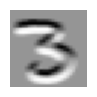

In [14]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

Looking good! Our top edges are black, and bottom edges are white (since they are the *opposite* of top edges). Now that our image contains negative numbers too, `matplotlib` has automatically changed our colors so that white is the smallest number in the image, black the highest, and zeros appear as gray.

We can try the same thing for left edges:

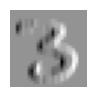

In [15]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

As we mentioned before, a convolution is the operation of applying such a kernel over a grid in this way. 

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="images/Lesson_06_00028.png">

Look at the shape of the result. If the original image has a height of `h` and a width of `w`, how many 3×3 windows can we find? As you can see from the example, there are `h-2` by `w-2` windows, so the image we get has a result as a height of `h-2` and a width of `w-2`.

>For more visualizations take a look at https://animatedai.github.io

### Convolutions in PyTorch

Convolution is such an important and widely used operation that PyTorch has it built in. It's called `F.conv2d` (recall that `F` is a fastai import from `torch.nn.functional`, as recommended by PyTorch). The PyTorch docs tell us that it includes these parameters:

- input:: input tensor of shape `(minibatch, in_channels, iH, iW)`
- weight:: filters of shape `(out_channels, in_channels, kH, kW)`

Here `iH,iW` is the height and width of the image (i.e., `28,28`), and `kH,kW` is the height and width of our kernel (`3,3`). But apparently PyTorch is expecting rank-4 tensors for both these arguments, whereas currently we only have rank-2 tensors (i.e., matrices, or arrays with two axes).

The reason for these extra axes is that PyTorch has a few tricks up its sleeve. The first trick is that PyTorch can apply a convolution to multiple images at the same time. That means we can call it on every item in a batch at once!

The second trick is that PyTorch can apply multiple kernels at the same time. So let's create the diagonal-edge kernels too, and then stack all four of our edge kernels into a single tensor:

In [16]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

To test this, we'll need a `DataLoader` and a sample mini-batch. 

In [17]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

/home/biagio/miniconda3/envs/iadb-dl/lib/python3.11/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


torch.Size([64, 1, 28, 28])

By default, fastai puts data on the GPU when using data blocks. Let's move it to the CPU for our examples:

In [18]:
xb,yb = to_cpu(xb),to_cpu(yb)

One batch contains 64 images, each of 1 channel, with 28×28 pixels. `F.conv2d` can handle multichannel (i.e., color) images too. A *channel* is a single basic color in an image—for regular full-color images there are three channels, red, green, and blue. PyTorch represents an image as a rank-3 tensor, with dimensions `[channels, rows, columns]`.

Kernels passed to `F.conv2d` need to be rank-4 tensors: `[channels_in, features_out, rows, columns]`. `edge_kernels` is currently missing one of these. We need to tell PyTorch that the number of input channels in the kernel is one, which we can do by inserting an axis of size one (this is known as a *unit axis*) in the first location, where the PyTorch docs show `in_channels` is expected. To insert a unit axis into a tensor, we use the `unsqueeze` method:

In [19]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

This is now the correct shape for `edge_kernels`. Let's pass this all to `conv2d`:

In [20]:
edge_kernels = edge_kernels.unsqueeze(1)

In [21]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

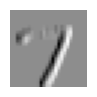

In [22]:
show_image(batch_features[0,0]);

It would be nice to not lose those two pixels on each axis. The way we do that is to add **padding**, which is simply additional pixels added around the outside of our image. Most commonly, pixels of zeros are added. 

### Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image, which can make things a lot simpler when we construct our architectures. Adding padding allows us to apply the kernels in the image corners.

<img src="images/Lesson_06_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/Lesson_06_00029.png">

If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is $\lfloor ks/2 \rfloor$. An even number for `ks` would require a different amount of padding on the top/bottom and left/right, but in practice we almost never use an even filter size.

So far, when we have applied the kernel to the grid, we have moved it one pixel over at a time. But we can jump further; for instance, we could move over two pixels after each kernel application. This is known as a *stride-2* convolution. The most common kernel size in practice is 3×3, and the most common padding is 1. Stride-2 convolutions are useful for decreasing the size of our outputs, and stride-1 convolutions are useful for adding layers without changing the output size.

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/Lesson_06_00030.png">

In an image of size `h` by `w`, using a padding of 1 and a stride of 2 will give us a result of size $\lfloor(h+1)/2\rfloor$ by $\lfloor(w+1)/2\rfloor$. The general formula for each dimension is $$\bigg\lfloor\frac{n + 2*pad - ks}{stride}\bigg\rfloor + 1$$ where `pad` is the padding, `ks`, the size of our kernel, and `stride` is the stride.

Let's now take a look at how the pixel values of the result of our convolutions are computed.

## Our First Convolutional Neural Network

There is no reason to believe that some particular edge filters are the most useful kernels for image recognition. Furthermore, we've seen that in later layers convolutional kernels become complex transformations of features from lower levels, but we don't have a good idea of how to manually construct these.

Instead, it would be best to learn the values of the kernels using SGD. This way, the model will learn the features that are useful for classification.

When we use convolutions instead of (or in addition to) regular linear layers we create a *convolutional neural network* (CNN).

### Creating the CNN

Let's create a basic neural network:

In [23]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1) 
)

>`nn.Conv2d` is the module equivalent of `F.conv2d`. It's more convenient than `F.conv2d` when creating an architecture, because it creates the weight matrix for us automatically when we instantiate it.


One thing to note in the network is that we didn't need to specify 28×28 as the input size. That's because a while linear layer needs a weight in the weight matrix for every pixel, so it needs to know how many pixels there are, a convolution is applied over each pixel automatically. The weights only depend on the number of input and output channels and the kernel size.

Let's look at the output shape:

In [24]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

This is not something we can use to do classification, since we need a single output activation per image, not a 28×28 map of activations. One way to deal with this is to use enough stride-2 convolutions such that the final layer is size 1. That is, after one stride-2 convolution the size will be 14×14, after two it will be 7×7, then 4×4, 2×2, and finally size 1.

Let's try that now. First, we'll define a function with the basic parameters we'll use in each convolution:

In [25]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

> Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

When we use a stride-2 convolution, we often increase the number of features at the same time. This is because we're decreasing the number of activations in the activation map by a factor of 4; we don't want to decrease the capacity of a layer by too much at a time.

> Note: The terms channels and features are largely used interchangeably, and refer to the size of the second axis of a weight matrix, which is, the number of activations per grid cell after a convolution. _Features_ is never used to refer to the input data, but _channels_ can refer to either the input data (generally channels are colors) or activations inside the network.

Here is how we can build a simple CNN:

In [26]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

Now the network outputs two activations, which map to the two possible levels in our labels:

In [27]:
simple_cnn(xb).shape

torch.Size([64, 2])

We can now create our `Learner`:

In [28]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

To see exactly what's going on in the model, we can use `summary`:

In [29]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

Note that the output of the final `Conv2d` layer is `64x2x1x1`. We need to remove those extra `1x1` axes; that's what `Flatten` does. It's basically the same as PyTorch's `squeeze` method, but as a module.


In [30]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.072507,0.034740,0.988224,00:02
1,0.021638,0.016491,0.994603,00:02


### Understanding Convolution Arithmetic

We can see from the summary that we have an input of size `64x1x28x28`. The axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order. The first layer is:

In [31]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

So we have 1 input channel, 4 output channels, and a 3×3 kernel. Let's check the weights of the first convolution:

In [32]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

The summary shows we have 40 parameters, and `4*1*3*3` is 36. What are the other four parameters? Let's see what the bias contains:

In [33]:
m[0].bias.shape

torch.Size([4])

We can now use this information to clarify the previous statement: "When we use a stride-2 convolution, we often increase the number of features because we're decreasing the number of activations in the activation map by a factor of 4; we don't want to decrease the capacity of a layer by too much at a time."

There is one bias for each channel. (Sometimes channels are called *features* or *filters* when they are not input channels.) The output shape is `64x4x14x14`, and this will therefore become the input shape to the next layer. The next layer, according to `summary`, has 296 parameters. Let's ignore the batch axis to keep things simple. So for each of `14*14=196` locations we are multiplying `296-8=288` weights (ignoring the bias for simplicity), so that's `196*288=56_448` multiplications at this layer. The next layer will have `7*7*(1168-16)=56_448` multiplications.

What happened here is that our stride-2 convolution halved the *grid size* from `14x14` to `7x7`, and we doubled the *number of filters* from 8 to 16, resulting in no overall change in the amount of computation. If we left the number of channels the same in each stride-2 layer, the amount of computation being done in the net would get less and less as it gets deeper. But we know that the deeper layers have to compute semantically rich features (such as eyes or fur), so we wouldn't expect that doing *less* computation would make sense.

## Color Images

A colour picture is a rank-3 tensor:

In [34]:
im = image2tensor(Image.open('images/Lesson2_grizzly.jpg'))
im.shape

torch.Size([3, 1000, 846])

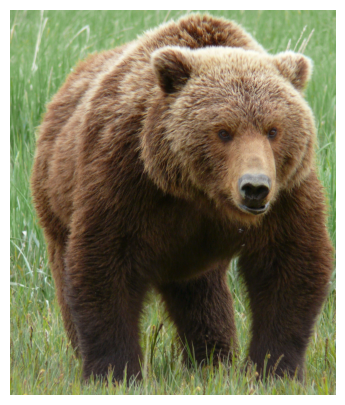

In [35]:
show_image(im);

The first axis contains the channels, red, green, and blue:

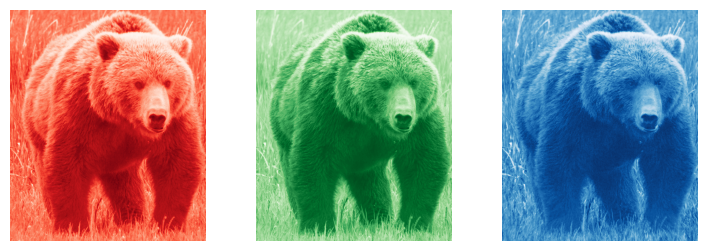

In [36]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

We saw what the convolution operation was for one filter on one channel of the image (our examples were done on a square). A convolutional layer will take an image with a certain number of channels (three for the first layer for regular RGB color images) and output an image with a different number of channels. Like our hidden size that represented the numbers of neurons in a linear layer, we can decide to have as many filters as we want, and each of them will be able to specialize, some to detect horizontal edges, others to detect vertical edges and so forth, to give something like we studied in <<chapter_production>>.

In one sliding window, we have a certain number of channels and we need as many filters (we don't use the same kernel for all the channels). So our kernel doesn't have a size of 3 by 3, but `ch_in` (for channels in) is 3 by 3. On each channel, we multiply the elements of our window by the elements of the coresponding filter, then sum the results (as we saw before) and sum over all the filters. In the example given in <<rgbconv>>, the result of our conv layer on that window is red + green + blue.

<img src="images/Lesson_06_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

So, in order to apply a convolution to a color picture we require a kernel tensor with a size that matches the first axis. At each location, the corresponding parts of the kernel and the image patch are multiplied together.

These are then all added together, to produce a single number, for each grid location, for each output feature, as shown in <<rgbconv2>>.

<img src="images/Lesson_06_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

Then we have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels and a height and width given by the formula outlined earlier. This give us `ch_out` tensors of size `ch_in x ks x ks` that we represent in one big tensor of four dimensions. In PyTorch, the order of the dimensions for those weights is `ch_out x ch_in x ks x ks`.

Additionally, we may want to have a bias for each filter. In the preceding example, the final result for our convolutional layer would be $y_{R} + y_{G} + y_{B} + b$ in that case. Like in a linear layer, there are as many bias as we have kernels, so the biases is a vector of size `ch_out`.

There are no special mechanisms required when setting up a CNN for training with color images. Just make sure your first layer has three inputs.

There are lots of ways of processing color images. For instance, you can change them to black and white, change from RGB to HSV (hue, saturation, and value) color space, and so forth. In general, it turns out experimentally that changing the encoding of colors won't make any difference to your model results, as long as you don't lose information in the transformation. So, transforming to black and white is a bad idea, since it removes the color information entirely (and this can be critical; for instance, a pet breed may have a distinctive color); but converting to HSV generally won't make any difference.

## Improving Training Stability

Since we are so good at recognizing 3s from 7s, let's move on to something harder—recognizing all 10 digits. 

In [37]:
path = untar_data(URLs.MNIST)

In [38]:
#hide
Path.BASE_PATH = path

In [39]:
path.ls()

(#2) [Path('training'),Path('testing')]

The data is in two folders named *training* and *testing*, so we have to tell `GrandparentSplitter` about that (it defaults to `train` and `valid`). We did do that in the `get_dls` function, which we create to make it easy to change our batch size later:

In [40]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

Remember, it's always a good idea to look at your data before you use it:

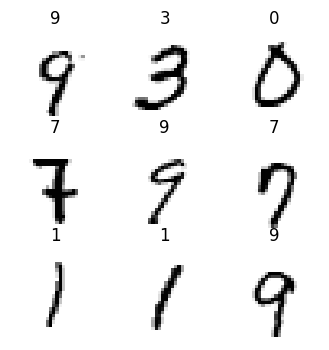

In [41]:
dls.show_batch(max_n=9, figsize=(4,4))

Now that we have our data ready, we can train a simple model on it.

### A Simple Baseline

Earlier we built a model based on a `conv` function like this:

In [42]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Let's start with a basic CNN as a baseline. We'll use the same one as earlier, but with one tweak: we'll use more activations. Since we have more numbers to differentiate, it's likely we will need to learn more filters.

As we discussed, we generally want to double the number of filters each time we have a stride-2 layer. One way to increase the number of filters throughout our network is to double the number of activations in the first layer–then every layer after that will end up twice as big as in the previous version as well.

But there is a subtle problem with this. Consider the kernel that is being applied to each pixel. By default, we use a 3×3-pixel kernel. That means that there are a total of 3×3 = 9 pixels that the kernel is being applied to at each location. Previously, our first layer had four output filters. That meant that there were four values being computed from nine pixels at each location. Think about what happens if we double this output to eight filters. Then when we apply our kernel we will be using nine pixels to calculate eight numbers. That means it isn't really learning much at all: the output size is almost the same as the input size. 

>Neural networks will only create useful features if they're forced to do so—that is, if the number of outputs from an operation is significantly smaller than the number of inputs.

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels then there are 25 pixels being used at each kernel application. Creating eight filters from this will mean the neural net will have to find some useful features:

In [43]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

As you'll see in a moment, we can look inside our models while they're training in order to try to find ways to make them train better. To do this we use the `ActivationStats` callback, which records the mean, standard deviation, and histogram of activations of every trainable layer:

In [44]:
from fastai.callback.hook import *

We want to train quickly, so that means training at a high learning rate. Let's see how we go at 0.06:

In [45]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [46]:
learn = fit()

/home/biagio/miniconda3/envs/iadb-dl/lib/python3.11/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.306211,2.307929,0.102800,00:13


This didn't train at all well! Let's find out why.

One handy feature of the callbacks passed to `Learner` is that they are made available automatically, with the same name as the callback class, except in `snake_case`. So, our `ActivationStats` callback can be accessed through `activation_stats`. 

`ActivationStats` includes some handy utilities for plotting the activations during training. `plot_layer_stats(idx)` plots the mean and standard deviation of the activations of layer number *`idx`*, along with the percentage of activations near zero. Here's the first layer's plot:

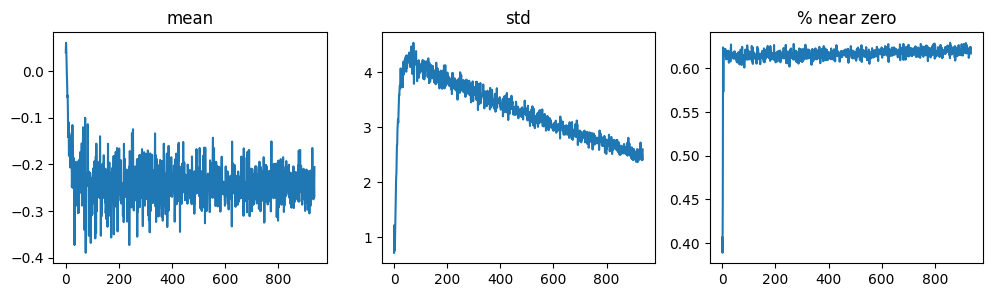

In [47]:
learn.activation_stats.plot_layer_stats(0)

Generally our model should have a consistent, or at least smooth, mean and standard deviation of layer activations during training. Activations near zero are particularly problematic, because it means we have computation in the model that's doing nothing at all (since multiplying by zero gives zero). When you have some zeros in one layer, they will therefore generally carry over to the next layer... which will then create more zeros. Here's the penultimate layer of our network:

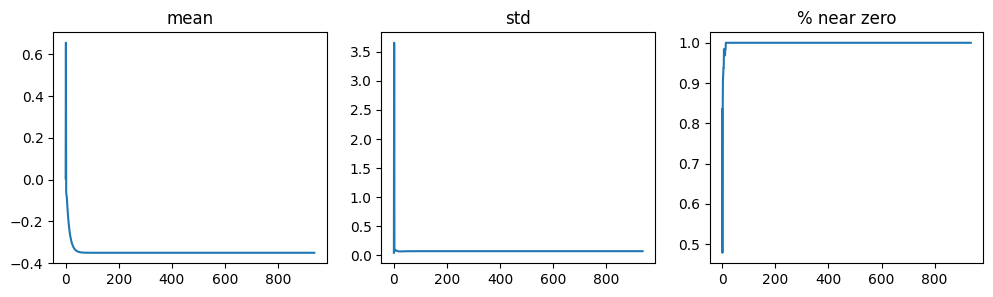

In [48]:
learn.activation_stats.plot_layer_stats(-2)

As expected, the problems get worse towards the end of the network, as the instability and zero activations compound over layers. Let's look at what we can do to make training more stable.

### Increase Batch Size

One way to make training more stable is to increase the batch size. Larger batches have gradients that are more accurate, since they're calculated from more data. On the downside, though, a larger batch size means fewer batches per epoch, which means less opportunities for your model to update weights. Let's see if a batch size of 512 helps:

In [49]:
dls = get_dls(512)

In [50]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.315653,2.302183,0.113500,00:09


Let's see what the penultimate layer looks like:

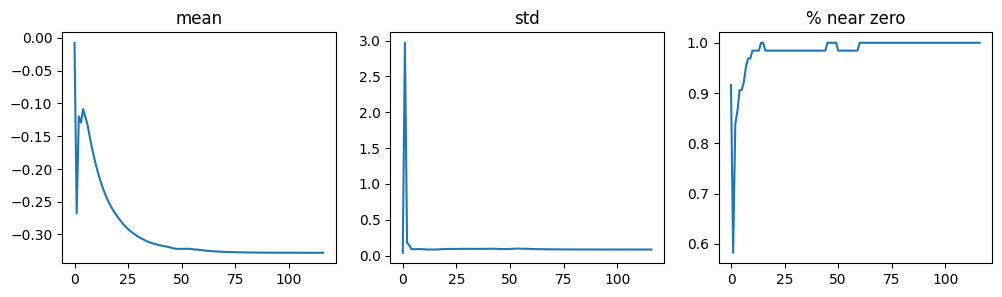

In [51]:
learn.activation_stats.plot_layer_stats(-2)

Again, we've got most of our activations near zero. Let's see what else we can do to improve training stability.

### 1cycle Training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we've seen. We probably don't want to end training with a high learning rate either, so that we don't skip over a minimum. But we want to train at a high learning rate for the rest of the training period, because we'll be able to train more quickly that way. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

In the article ["Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates"](https://arxiv.org/abs/1708.07120) was proposed a schedule for learning rate separated into two phases: one where the learning rate grows from the minimum value to the maximum value (*warmup*), and one where it decreases back to the minimum value (*annealing*). This combination of approaches was called *1cycle training*.

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

- By training with higher learning rates, we train faster—hence the *super-convergence* of the title.
- By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.

The second point is an interesting and subtle one; it is based on the observation that a model that generalizes well is one whose loss would not change very much if you changed the input by a small amount. If a model trains at a large learning rate for quite a while, and can find a good loss when doing so, it must have found an area that also generalizes well, because it is jumping around a lot from batch to batch (that is basically the definition of a high learning rate). The problem is that, as we have discussed, just jumping to a high learning rate is more likely to result in diverging losses, rather than seeing your losses improve. So we don't jump straight to a high learning rate. Instead, we start at a low learning rate, where our losses do not diverge, and we allow the optimizer to gradually find smoother and smoother areas of our parameters by gradually going to higher and higher learning rates.

Then, once we have found a nice smooth area for our parameters, we want to find the very best part of that area, which means we have to bring our learning rates down again. This is why 1cycle training has a gradual learning rate warmup, and a gradual learning rate cooldown. Many researchers have found that in practice this approach leads to more accurate models and trains more quickly. 

We can use 1cycle training in fastai by calling `fit_one_cycle`:

In [52]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [53]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.200606,0.074460,0.975100,00:08


We're finally making some progress! It's giving us a reasonable accuracy now.

We can view the learning rate and momentum throughout training by calling `plot_sched` on `learn.recorder`. 

`learn.recorder` (as the name suggests) records everything that happens during training, including losses, metrics, and hyperparameters such as learning rate and momentum:

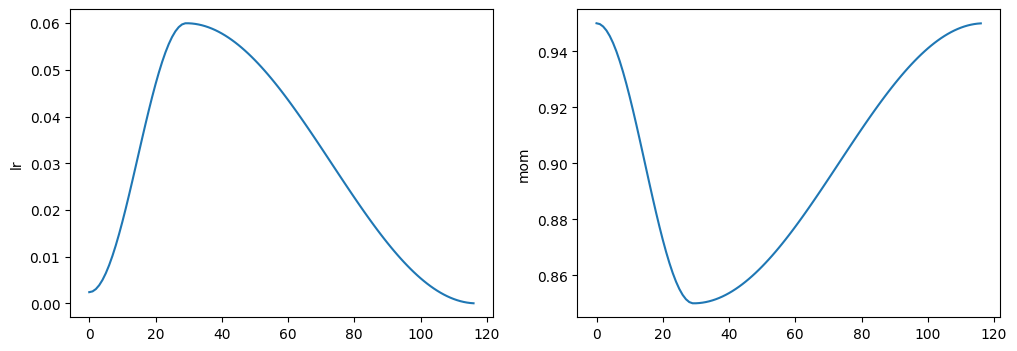

In [54]:
learn.recorder.plot_sched()

Let's take a look at our layer stats again:

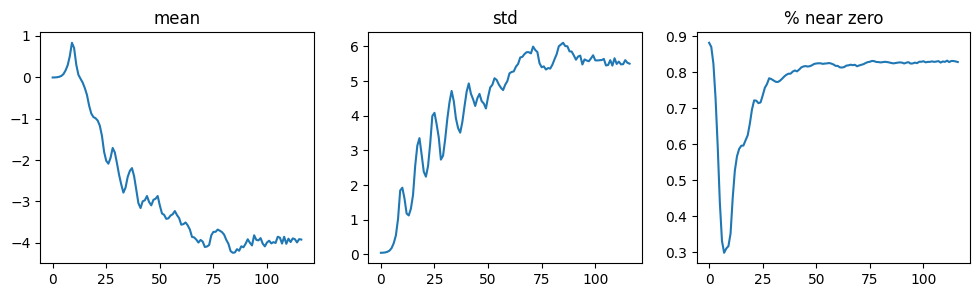

In [55]:
learn.activation_stats.plot_layer_stats(-2)

The percentage of near-zero weights is getting much better, although it's still quite high.

This shows a classic "bad training." We start with nearly all activations at zero. Then, over the first few batches we see the number of nonzero activations exponentially increasing. But it goes too far, and collapses! It almost looks like training restarts from scratch. 

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.

### Batch Normalization

To fix the slow training and poor final results we ended up with in the previous section, we need to fix the initial large percentage of near-zero activations, and then try to maintain a good distribution of activations throughout training.

Sergey Ioffe and Christian Szegedy presented a solution to this problem in the 2015 paper ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167). In the abstract, they describe just the problem that we've seen:

>Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their solution, they say is:

>Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

The paper caused great excitement as soon as it was released because clearly demonstrated that batch normalization could train a model that was even more accurate than the current state of the art (the *Inception* architecture) and around 5x faster.

<img alt="Impact of batch normalization" width="553" caption="Impact of batch normalization (courtesy of Sergey Ioffe and Christian Szegedy)" id="batchnorm" src="images/att_00046.png">

Batch normalization (often just called *batchnorm*) works by taking an average of the mean and standard deviations of the activations of a layer and using those to normalize the activations. However, this can cause problems because the network might want some activations to be really high in order to make accurate predictions. So they also added two learnable parameters (meaning they will be updated in the SGD step), usually called `gamma` and `beta`. After normalizing the activations to get some new activation vector `y`, a batchnorm layer returns `gamma*y + beta`.

That's why our activations can have any mean or variance, independent from the mean and standard deviation of the results of the previous layer. Those statistics are learned separately, making training easier on our model. The behavior is different during training and validation: during training, we use the mean and standard deviation of the batch to normalize the data, while during validation we instead use a running mean of the statistics calculated during training.

Let's add a batchnorm layer to `conv`:

In [56]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

and fit our model:

In [57]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time


That's a great result! Let's take a look at `color_dim`:

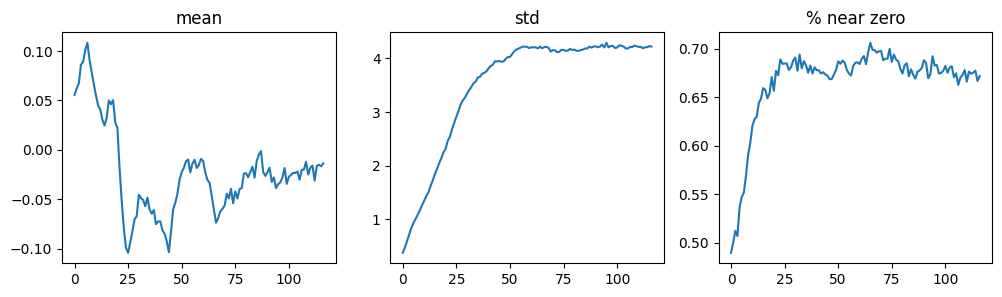

In [58]:
learn.activation_stats.plot_layer_stats(-2)

This is just what we hope to see: a smooth development of activations, with no "crashes." Batchnorm has really delivered on its promise here! In fact, batchnorm has been so successful that we see it (or something very similar) in nearly all modern neural networks.

An interesting observation about models containing batch normalization layers is that they tend to generalize better than models that don't contain them. Although we haven't as yet seen a rigorous analysis of what's going on here, most researchers believe that the reason for this is that batch normalization adds some extra randomness to the training process. Each mini-batch will have a somewhat different mean and standard deviation than other mini-batches. Therefore, the activations will be normalized by different values each time. In order for the model to make accurate predictions, it will have to learn to become robust to these variations. In general, adding additional randomization to the training process often helps.
